In [2]:
import gym
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [3]:
from gym.wrappers import Monitor

env = gym.make("MontezumaRevenge-v0")
env = Monitor(env, './video', force=True)

In [5]:
from rllr.utils.plotting.video import show_video

In [6]:
done = False
env.reset()
while not done:
    a = env.action_space.sample()
    s, r, done, info = env.step(a)

show_video()

In [394]:
device = "cpu"
import torch
from skimage.transform import resize


def rollout(env):
    
    states, next_states, actions = [],  [], []
    done = False
    
    state = env.reset()
    i = 0
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        states.append(state/255.) # resize(state, (60, 40))
        next_states.append(next_state/255.)
        actions.append(action)
        state = next_state
        i+=1
    
    states = torch.from_numpy(np.array(states)).to(device, dtype=torch.float32)
    next_states = torch.from_numpy(np.array(next_states)).to(device, dtype=torch.float32)
    actions = torch.from_numpy(np.array(actions)).to(device)
    return states, next_states, actions

In [395]:
import numpy as np

env = gym.make("MontezumaRevenge-v0")
env = Monitor(env, './video', force=True)

states, next_states, actions = rollout(env)

In [396]:
states.size()

torch.Size([378, 210, 160, 3])

In [397]:
actions.size()

torch.Size([378])

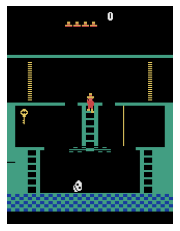

In [398]:
plt.axis('off')
plt.imshow(states[100])
plt.show()

In [399]:
from rllr.models.encoders import VAE

net = VAE(tuple(states.size()[1:]), n_channels=[16, 32], kernel_sizes=[5, 5], strides=[1, 1], hidden_sizes=[32]).to(device)
net

VAE(
  (enc_conv_net): Sequential(
    (0): Permute()
    (1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
  )
  (enc_mu): Sequential(
    (0): Linear(in_features=982528, out_features=32, bias=True)
  )
  (enc_var): Sequential(
    (0): Linear(in_features=982528, out_features=32, bias=True)
  )
  (dec_fc): Sequential(
    (0): Linear(in_features=32, out_features=982528, bias=True)
    (1): ReLU(inplace=True)
  )
  (dec_conv_net): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 3, kernel_size=(5, 5), stride=(1, 1))
    (3): Permute()
  )
)

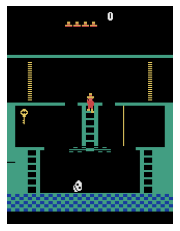

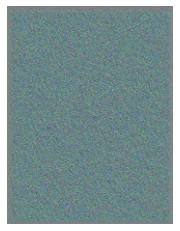

In [400]:
image_size = tuple(states.size()[1:])
dec = net(states)[0].detach()

plt.axis('off')
plt.imshow(states[100])
plt.show()

plt.axis('off')
plt.imshow(dec[100])
plt.show()

In [401]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 10


def chunks(x, n):
    for i in range(0, x.size()[0], n):
        yield x[i:i + n, :]


"""
Initialize the network and the Adam optimizer
"""
image_size = tuple(states.size()[1:])
net = VAE(image_size, n_channels=[16, 32], kernel_sizes=[5, 5], strides=[1, 1], hidden_sizes=[32]).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""

done = True
env = gym.make("MontezumaRevenge-v0")
env = Monitor(env, './video', force=True)

for epoch in range(num_epochs):
    states, _, _ = rollout(env)
    states = states.to(device)
    
    # Feeding a batch of images into the network to obtain the output image, mu, and logVar
    for i, batch in enumerate(chunks(states, batch_size)):
        out, mu, logVar = net(batch)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, batch, size_average=False) + kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch {}, Batch{}: Loss {}'.format(epoch, i, loss))

/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Batch0: Loss 8694699.0
Epoch 0, Batch1: Loss 17548568428544.0
Epoch 0, Batch2: Loss 9368460.0
Epoch 0, Batch3: Loss 1361536.0


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1, Batch0: Loss 10293464.0
Epoch 1, Batch1: Loss 12972941.0
Epoch 1, Batch2: Loss 13780506.0
Epoch 1, Batch3: Loss 14079384.0
Epoch 1, Batch4: Loss 12333357.0
Epoch 1, Batch5: Loss 2030804.25
Epoch 2, Batch0: Loss 9613630.0
Epoch 2, Batch1: Loss 8934856.0
Epoch 2, Batch2: Loss 8113806.5
Epoch 2, Batch3: Loss 6819004.5
Epoch 2, Batch4: Loss 983287.6875
Epoch 3, Batch0: Loss 5334871.0
Epoch 3, Batch1: Loss 5043642.0
Epoch 3, Batch2: Loss 4808720.0
Epoch 3, Batch3: Loss 4587305.0
Epoch 3, Batch4: Loss 4364636.5
Epoch 3, Batch5: Loss 4171177.5
Epoch 3, Batch6: Loss 2647340.0
Epoch 4, Batch0: Loss 3939376.25
Epoch 4, Batch1: Loss 3835036.0
Epoch 4, Batch2: Loss 3745681.0
Epoch 4, Batch3: Loss 3652073.0
Epoch 4, Batch4: Loss 300859.8125
Epoch 5, Batch0: Loss 3465808.25
Epoch 5, Batch1: Loss 3334015.75
Epoch 5, Batch2: Loss 3204532.0
Epoch 5, Batch3: Loss 3111150.25
Epoch 5, Batch4: Loss 3032778.0
Epoch 5, Batch5: Loss 694773.1875
Epoch 6, Batch0: Loss 2994173.5
Epoch 6, Batch1: Loss 29

/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 8, Batch0: Loss 2689919.0
Epoch 8, Batch1: Loss 2625938.75
Epoch 8, Batch2: Loss 2633679.25
Epoch 8, Batch3: Loss 1032655.125
Epoch 9, Batch0: Loss 2662511.75
Epoch 9, Batch1: Loss 2647336.5
Epoch 9, Batch2: Loss 2626539.25
Epoch 9, Batch3: Loss 2597647.5
Epoch 9, Batch4: Loss 2542561.75
Epoch 9, Batch5: Loss 2529959.75
Epoch 9, Batch6: Loss 2541952.5
Epoch 9, Batch7: Loss 2523428.5
Epoch 9, Batch8: Loss 2506684.25
Epoch 9, Batch9: Loss 2502904.75
Epoch 9, Batch10: Loss 2535363.75
Epoch 9, Batch11: Loss 2494749.5
Epoch 9, Batch12: Loss 2425338.0
Epoch 9, Batch13: Loss 2213244.0


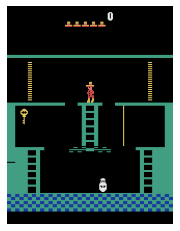

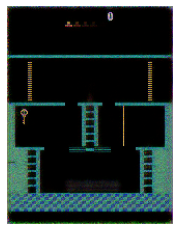

In [402]:
dec = net(states)[0].detach()
i = 1

plt.axis('off')
plt.imshow(states[i])
plt.show()

plt.axis('off')
plt.imshow(dec[i])
plt.show()

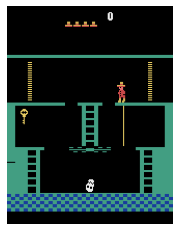

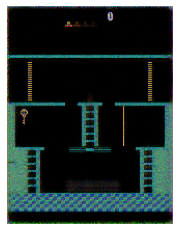

In [406]:
i = 56

plt.axis('off')
plt.imshow(states[i])
plt.show()

plt.axis('off')
plt.imshow(dec[i])
plt.show()

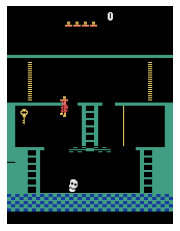

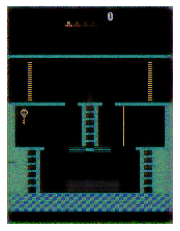

In [407]:
i = 78

plt.axis('off')
plt.imshow(states[i])
plt.show()

plt.axis('off')
plt.imshow(dec[i])
plt.show()

In [8]:
c = [(1, 1), (3, 1), (0, 2), (4, 2), ()]
cx = sorted([x[0] for x in c])
assert(len(cx)%2==0)
hs = [(cx[i] + cx[-(i+1)])/2 for i in range(int(len(cx)/2))]
hs   

[2.0, 2.0]